# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import tools.davinci as dv
import tools.metrics as ms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tools.detector import PoseLandmarkerDetector

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
%%script True  # Comment this line to run the code below

extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

extractor.extract_frames()

### Data Augmentation

Data augmentation will help to increase the dataset in size, adding robustness and improvng the accuracy of the model. For data augmentation, the following techniques will be applied for each image:
- Vertical flipping
- Horizontal flipping
- Random rotations (from 30 to 330 degrees)

In [4]:
%%script True  # Comment this line to run the code below

extractor.flip_frames(target="assets/frames_vflip", axis=0)
extractor.flip_frames(target="assets/frames_hflip", axis=1)
extractor.random_rotate_frames(target="assets/frames_rotated", minr=30, maxr=330)

### Skeleton Joints Extraction

To extract keypoints, the PoseLandmarker will be used. It is not only estimates the pose of a human, but also depth, which can help to compute real distances, and not only projections. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

Joints:
Image: assets/frames/aJKL0ahn1Dk_0.jpg
Nose: [0.4762490689754486, 0.20601987838745117, -1.0868065357208252]
Left Eye: [0.5350305438041687, 0.17016959190368652, -1.0235446691513062]
Right Eye: [0.4342111349105835, 0.16592013835906982, -0.9854247570037842]
Left Ear: [0.5864210724830627, 0.20359766483306885, -0.5734831094741821]
Right Ear: [0.41092267632484436, 0.19395452737808228, -0.39666932821273804]
Left Shoulder: [0.6917808055877686, 0.445148766040802, -0.4841667413711548]
Right Shoulder: [0.30522429943084717, 0.42656391859054565, 0.15310324728488922]
Left Elbow: [0.9143170118331909, 0.7891113758087158, -0.8733211755752563]
Right Elbow: [0.11357158422470093, 0.7052987813949585, -0.2079153209924698]
Left Wrist: [0.6155726909637451, 0.7124630212783813, -1.5965979099273682]
Right Wrist: [0.16248920559883118, 0.616131067276001, -1.4786337614059448]
Left Hip: [0.5796119570732117, 0.9782642126083374, -0.2426689714193344]
Right Hip: [0.3403915464878082, 0.9706331491470337, 0.2466360

I0000 00:00:1718729423.278539  835852 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718729423.344190  836057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718729423.348644  836067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


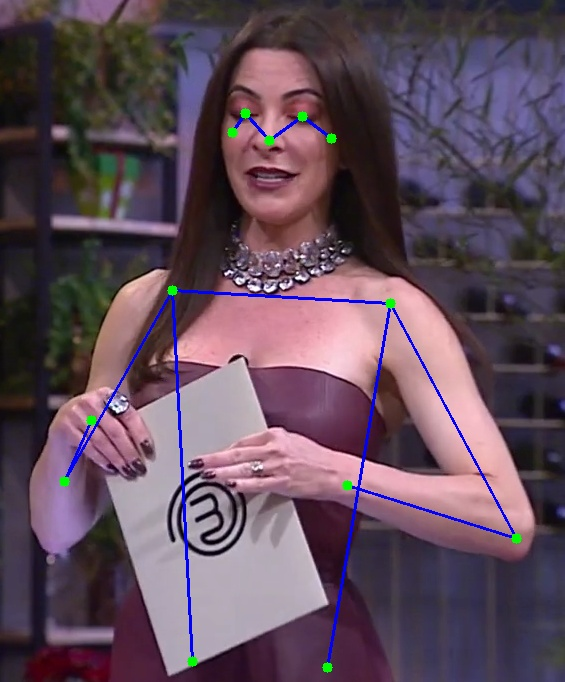

In [5]:
detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")
result = detector.detect("assets/frames/aJKL0ahn1Dk_0.jpg")
print(result)
dv.draw(result, inline=True)

In [6]:
%%script True  # Comment this line to run the code below

def apply_model(model, df, target, output_csv):
    keypoints = model.detect_multi(df, target, depth=True, align=True)
    result_df = pd.concat(keypoints, axis=1, ignore_index=True).T
    result_df.to_csv(output_csv, index=False)

apply_model(
    detector,
    df,
    "assets/frames",
    "assets/annotations/keypoints_plm.csv"
)

In [7]:
plm_df = pd.read_csv("assets/annotations/keypoints_plm.csv")
plm_df.head()

,nose_X,nose_Y,nose_Z,left_eye_X,left_eye_Y,left_eye_Z,right_eye_X,right_eye_Y,right_eye_Z,left_ear_X,...,left_knee_Z,right_knee_X,right_knee_Y,right_knee_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,right_ankle_X,right_ankle_Y,right_ankle_Z
0,0.476249,0.206020,0.0,0.535031,0.170170,0.0,0.434211,0.165920,0.0,0.586421,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1,0.492948,0.208999,0.0,0.546848,0.175521,0.0,0.456288,0.171056,0.0,0.602341,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,0.503459,0.200641,0.0,0.557451,0.169485,0.0,0.465345,0.163133,0.0,0.612083,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,0.513293,0.199684,0.0,0.561677,0.170290,0.0,0.471453,0.167836,0.0,0.610161,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
4,0.505559,0.198806,0.0,0.557377,0.162941,0.0,0.465385,0.163360,0.0,0.608117,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


### Combine all DataFrames

In [8]:
initial_df = pd.read_csv("assets/annotations/annotations.csv")
print("initial_df shape:", initial_df.shape)

plm_df = pd.read_csv("assets/annotations/keypoints_plm.csv")
plm_df_merged = pd.concat([initial_df, plm_df], axis=1)
print("plm_df_merged shape:", plm_df_merged.shape)

plm_hflip_df = pd.read_csv("assets/annotations/keypoints_plm_hflip.csv")
plm_hflip_df_merged = pd.concat([initial_df, plm_hflip_df], axis=1)
print("plm_hflip_df_merged shape:", plm_hflip_df_merged.shape)

plm_vflip_df = pd.read_csv("assets/annotations/keypoints_plm_vflip.csv")
plm_vflip_df_merged = pd.concat([initial_df, plm_vflip_df], axis=1)
print("plm_vflip_df_merged shape:", plm_vflip_df_merged.shape)

plm_rotated_df = pd.read_csv("assets/annotations/keypoints_plm_rotated.csv")
plm_rotated_df_merged = pd.concat([initial_df, plm_rotated_df], axis=1)
print("plm_rotated_df_merged shape:", plm_rotated_df_merged.shape)

# combined_df = pd.concat([plm_df_merged, plm_hflip_df_merged, plm_vflip_df_merged, plm_rotated_df_merged], axis=0).reset_index(drop=True)
combined_df = pd.concat([plm_df_merged], axis=0).reset_index(drop=True)
print("combined_df shape:", combined_df.shape)

initial_df shape: (8087, 9)
plm_df_merged shape: (8087, 60)
plm_hflip_df_merged shape: (8087, 60)
plm_vflip_df_merged shape: (8087, 60)
plm_rotated_df_merged shape: (8087, 60)
combined_df shape: (8087, 60)


### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [9]:
# Remove all columns that represent legs
columns_drop = combined_df.columns[combined_df.columns.get_loc('right_hip_Z')+1:]
cleaned_df = combined_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Z')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='any')
cleaned_df = cleaned_df.reset_index(drop=True)

# For now, later will be changed to "all" and only for eyes and nose
cleaned_df = cleaned_df.dropna(subset=["nose_X", "nose_Y", "nose_Z", "left_eye_X", "left_eye_Y", "left_eye_Z",
                                       "right_eye_X", "right_eye_Y", "right_eye_Z", "left_ear_X", "left_ear_Y",
                                       "left_ear_Z", "right_ear_X", "right_ear_Y", "right_ear_Z"], how='any')
cleaned_df = cleaned_df.reset_index(drop=True)
print("cleaned_df shape:", cleaned_df.shape)

cleaned_df shape: (2787, 48)


## Step 2: Feature Extraction

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [10]:
segments = ms.segmentate(cleaned_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment, 10) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 279
Original (first 5): [(0, 50), (51, 52), (53, 62), (63, 63), (64, 75)]
Total number of normalized segments: 279
Normalized (first 5): [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]


### Curve Simplification

![Ramer-Douglas_Peucker algorithm visualization](media/rdp.gif)

To extract trajectory features, inspired by [Tomasz Sapiński](https://www.mdpi.com/1099-4300/21/7/646), the curve simplification (CS) algorithm, based on the [Ramer-Douglas-Peucker algorithm](https://rdp.readthedocs.io/en/latest/), will be applied, for 2D joints separately for each segment, that returns a set of key points that are essential for accurately representing the original curve. The algorithm will return the following:
 
- The critical frames in the motion sequence that capture significant changes in the movement.
- The simplified version of the original motion trajectory (data reduction).

The CS algorithm will be called before each feature extraction procedure.

In [11]:
segment = norm_segments[0]

#### Vector Features

Each movement of each joint can be represented as a vector with its own magnitude, direction and slope.

In [12]:
v_f = segment.get_vectors(["nose", "left_shoulder", "right_shoulder", "left_elbow", 
                           "right_elbow", "left_wrist", "right_wrist"])
v_f

{'Label': 'Happy',
 'Distance_Hip_nose_1': 2.4279448282630067,
 'Distance_Hip_nose_2': 2.4299311616460395,
 'Distance_Hip_nose_3': 2.40047745473867,
 'Distance_Hip_nose_4': 2.4844656189709386,
 'Distance_Hip_nose_5': 2.4182086399054383,
 'Distance_Hip_nose_6': 2.4269478366635924,
 'Distance_Hip_nose_7': 2.376162124759394,
 'Distance_Hip_nose_8': 2.3974024027067413,
 'Distance_Hip_nose_9': 2.340060440397832,
 'Distance_Hip_left_shoulder_1': 1.8877700747323631,
 'Distance_Hip_left_shoulder_2': 1.7990656119116557,
 'Distance_Hip_left_shoulder_3': 1.7729680347421413,
 'Distance_Hip_left_shoulder_4': 1.9134733297513915,
 'Distance_Hip_left_shoulder_5': 1.8706732211107098,
 'Distance_Hip_left_shoulder_6': 1.880320838971297,
 'Distance_Hip_left_shoulder_7': 1.8087571337855017,
 'Distance_Hip_left_shoulder_8': 1.8803579583078127,
 'Distance_Hip_left_shoulder_9': 1.8790121440925869,
 'Distance_Hip_right_shoulder_1': 1.772712337598813,
 'Distance_Hip_right_shoulder_2': 1.8385353867763226,
 'Dist

#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a particular emotion. In that case for each segment the number of each emotion will be calculated (e.g. <code>[[Happy, Sad, Happy], [Happy, Happy, Angry]]</code> will be converted to <code>{Happy: 4, Sad: 1, Angry: 1, Fear: 0, ...}</code>).

In [13]:
emotion_count = segment.count_emotions()

print("Emotion count:", emotion_count)

Emotion count: {'Happy': 27, 'Sad': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Anger': 0, 'Neutral': 3}


## Step 3: Clustering

### Prepare data to cluster

In [14]:
features = {}
pairs = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"]

for i in range(len(norm_segments)):
    feature = norm_segments[i].get_vectors(pairs=pairs)
    features[f"s_{i}"] = feature

features_df = pd.DataFrame.from_dict(features, orient='index')
print(features_df.shape)
features_df.head()

(279, 64)


,Label,Distance_Hip_nose_1,Distance_Hip_nose_2,Distance_Hip_nose_3,Distance_Hip_nose_4,Distance_Hip_nose_5,Distance_Hip_nose_6,Distance_Hip_nose_7,Distance_Hip_nose_8,Distance_Hip_nose_9,...,Distance_Hip_left_wrist_9,Distance_Hip_right_wrist_1,Distance_Hip_right_wrist_2,Distance_Hip_right_wrist_3,Distance_Hip_right_wrist_4,Distance_Hip_right_wrist_5,Distance_Hip_right_wrist_6,Distance_Hip_right_wrist_7,Distance_Hip_right_wrist_8,Distance_Hip_right_wrist_9
s_0,Happy,2.427945,2.429931,2.400477,2.484466,2.418209,2.426948,2.376162,2.397402,2.340060,...,0.862100,1.661547,1.238822,1.513190,0.916723,1.985149,1.803300,1.021863,1.067289,0.994120
s_1,Fear,1.083503,1.083503,1.083503,1.083503,1.083503,1.083503,1.083503,1.083503,1.038933,...,1.048535,0.828951,0.828951,0.828951,0.828951,0.828951,0.828951,0.828951,0.828951,0.847094
s_2,Happy,1.209474,1.260762,1.249675,1.233127,1.211896,1.276547,1.165220,1.119758,1.036713,...,0.464421,1.631476,1.824506,1.533621,0.927374,0.675717,0.660676,0.875164,1.215289,0.463535
s_3,Neutral,2.004206,2.004206,2.004206,2.004206,2.004206,2.004206,2.004206,2.004206,2.004206,...,1.314851,1.899266,1.899266,1.899266,1.899266,1.899266,1.899266,1.899266,1.899266,1.899266
s_4,Happy,1.255404,1.301105,1.292354,1.283522,1.192461,1.167080,1.166808,1.182032,1.194809,...,0.669871,0.752614,0.734324,0.685243,0.651057,0.493188,0.430903,0.522126,0.526145,0.524347


In [15]:
label_counts = features_df['Label'].value_counts()
print(label_counts)

labels_to_remove = ["Sad", "Surprise", "Disgust", "Fear"]
features_df = features_df[~features_df['Label'].isin(labels_to_remove)]
label_counts = features_df['Label'].value_counts()
print(label_counts)

Label
Neutral     132
Happy        78
Anger        38
Sad           9
Surprise      8
Disgust       8
Fear          6
Name: count, dtype: int64
Label
Neutral    132
Happy       78
Anger       38
Name: count, dtype: int64


### Analyze the initial labels

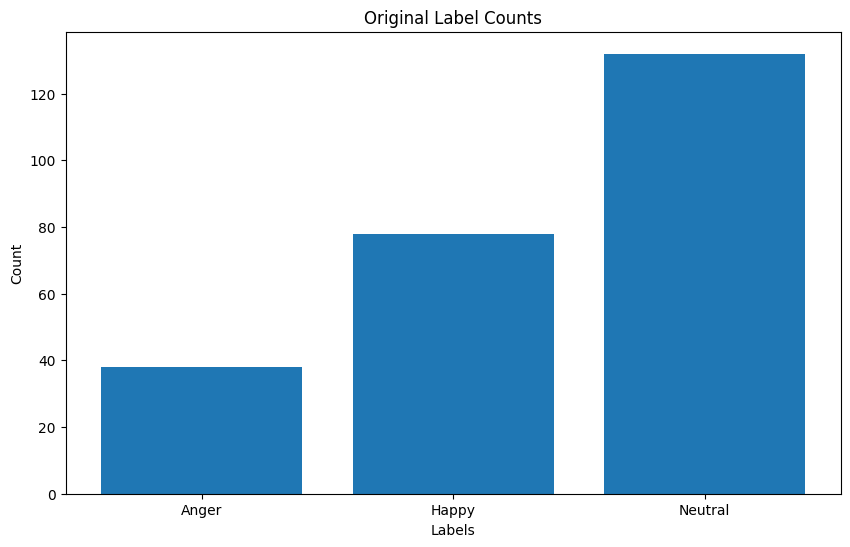

In [16]:
def plot_label_counts(labels, title, x="Labels", y="Count"):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

plot_label_counts(features_df["Label"], title="Original Label Counts")

### Hierarchical Clustering

In [17]:
scaler = StandardScaler()
smote = SMOTE(random_state=42)

data = features_df.drop(columns=['Label'])
# data = data.fillna(data.mean())
scaled_data = scaler.fit_transform(data)

cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
cluster_labels = cluster.fit_predict(scaled_data)

data['Cluster'] = cluster_labels

# Silhouette Score
silhouette_avg = silhouette_score(data, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(data, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

# pairplot = sns.pairplot(data[:, :10], hue='Cluster', palette='rainbow')
# pairplot.figure.suptitle("Pairplot of Clusters (for the first 10 columns)", y=1.02)
# plt.show()

Silhouette Score: 0.7043072408933684
Davies-Bouldin Index: 0.1904308796046256


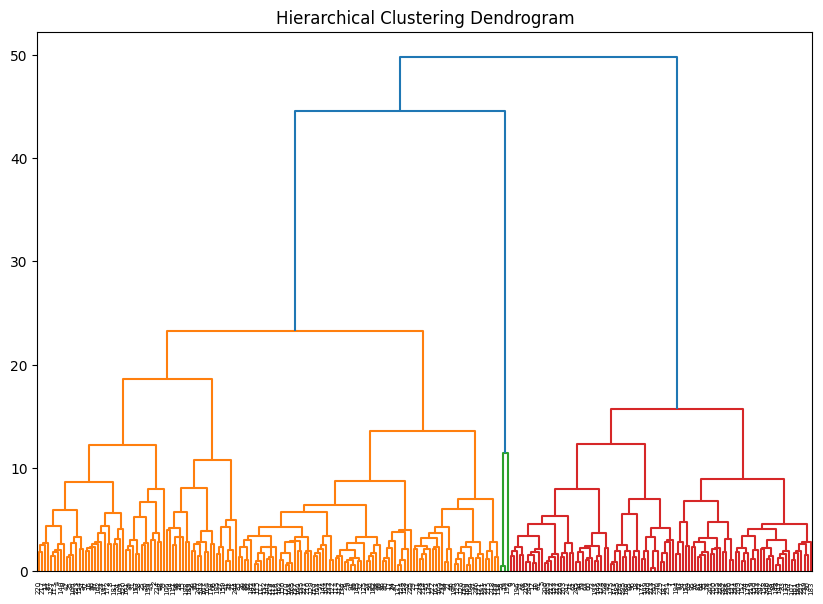

In [18]:
linked = linkage(data, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Adjusted Rand Index: -0.004386859903145051
Normalized Mutual Information: 0.01842192698802997


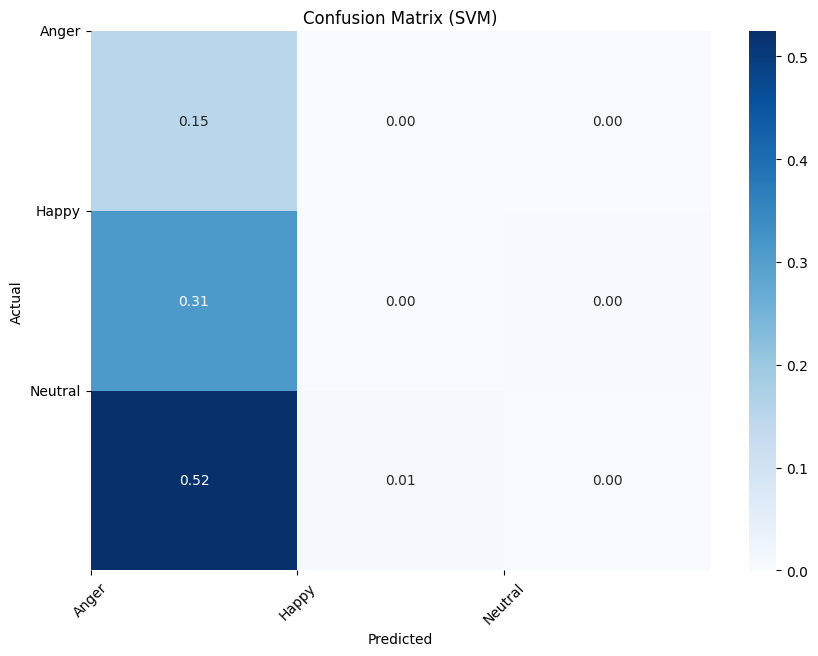

In [19]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(features_df['Label'])

ari = metrics.adjusted_rand_score(true_labels, cluster_labels)
nmi = metrics.normalized_mutual_info_score(true_labels, cluster_labels)

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')

cm = confusion_matrix(true_labels, cluster_labels)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (SVM)')
plt.xticks(ticks=np.arange(3), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(3), labels=label_encoder.classes_, rotation=0)
plt.show()

## Step 4: Classification

In [20]:
RANDOM_STATE = 42
NUM_CLASSES = 3
TEST_SIZE = 0.15

scaler = StandardScaler()
label_encoder = LabelEncoder()

X = features_df.drop(['Label'], axis=1)
y = features_df['Label']
X_scaled = scaler.fit_transform(X)
labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("X_resampled:", X_resampled.shape, "y_resampled:", y_resampled.shape)

X_train: (210, 63) X_test: (38, 63)
X_resampled: (345, 63) y_resampled: (345,)


### Support Vector Machines (SVM)

According to [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/svm.html), SVM will be useful in classification problem in high dimensional spaces and still effective if number of dimensions is higher than number of samples. In addition, it is fast and memory efficient. Also, it can be used in datasets where each class is unequally represented by manually adjusting weights, suggested by [Hengtao Tantai](https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75).

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.8115942028985506
Accuracy: 50.00%
Precision: 0.43
Recall: 0.50
F1-Score: 0.45


/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


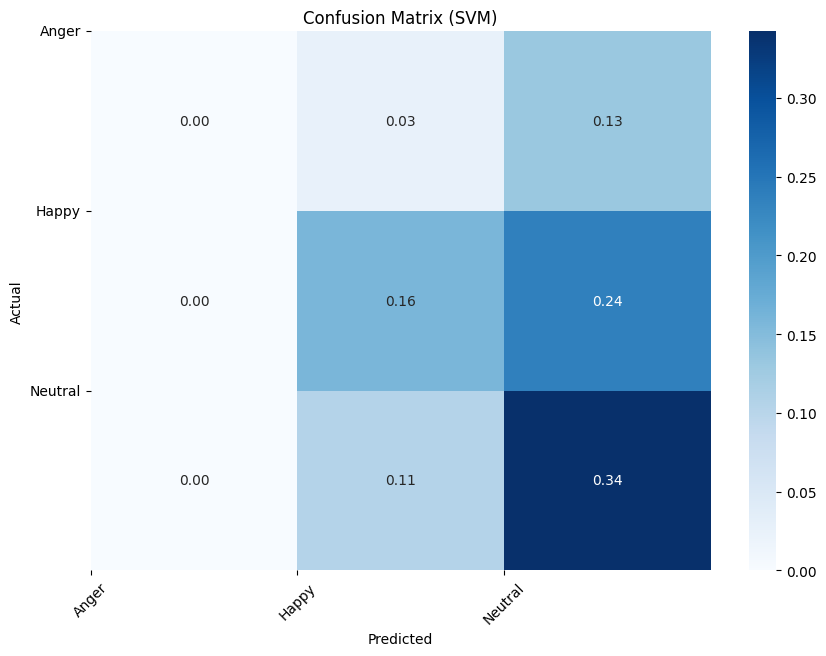

In [21]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (SVM)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

The most important is to understand how each feature affected the prediction of the human's emotions. For that purpose Shapeley values will be used. Computed result will be shown below (to avoid repetitve long computations).

In [22]:
# svm = SVC(class_weight="balanced", probability=True)  # weights for imbalanced classes
# svm.fit(X_train, y_train)

# X_train_sampled = shap.sample(X_train, 100) 

# explainer = shap.KernelExplainer(svm.predict_proba, X_train_sampled, link="logit")
# shap_values = explainer(X_test[:100])

# exp_cont = pd.DataFrame(shap_values[0].values)
# exp_cont.describe()
# shap.summary_plot(shap_values, X_test[:100])

### Random Forest

Accuracy: 50.00%
Precision: 0.50
Recall: 0.50
F1-Score: 0.50


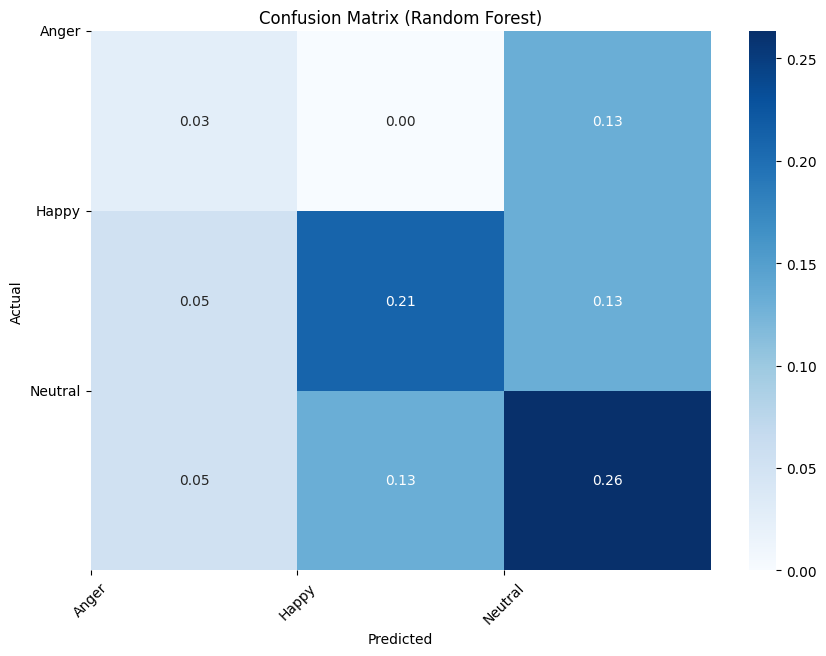

In [23]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Random Forest)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

### Neural Network

Epoch 1/100


/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3763 - loss: 1.1568 - val_accuracy: 0.5429 - val_loss: 1.0468
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.5844 - loss: 0.9763 - val_accuracy: 0.4286 - val_loss: 1.0559
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.5720 - loss: 0.9297 - val_accuracy: 0.5714 - val_loss: 0.9649
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.6840 - loss: 0.8454 - val_accuracy: 0.6571 - val_loss: 0.8187
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7027 - loss: 0.7880 - val_accuracy: 0.6286 - val_loss: 0.9381
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.7558 - loss: 0.6970 - val_accuracy: 0.7143 - val_loss: 0.6951
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7705 - loss: 0.7002 - val_accuracy: 0.7143 - val_loss: 0.7414
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.7730 - loss: 0.6654 - val_accuracy: 0.6571 -

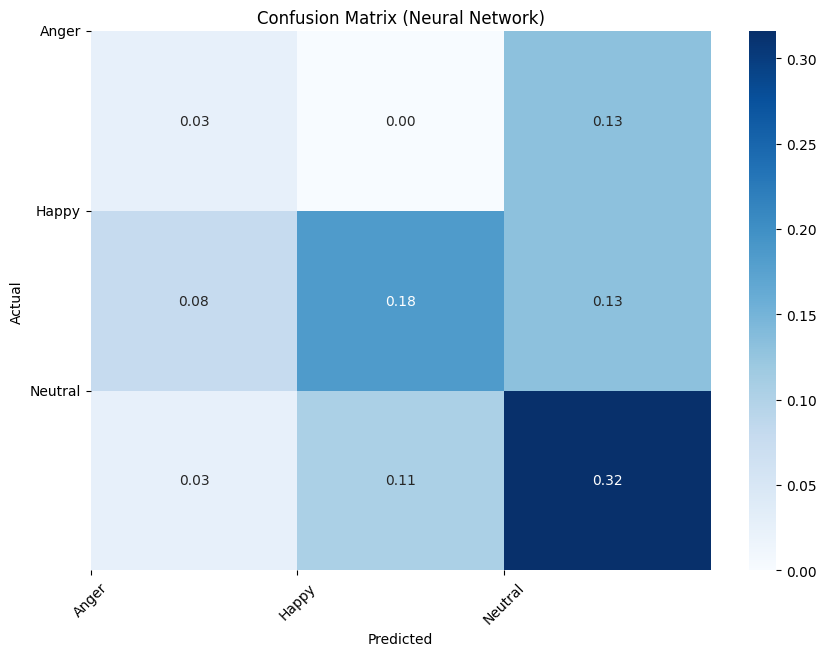

In [24]:
EPOCHS = 100
input_shape = X_resampled.shape[1]
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(X_resampled, y_resampled, epochs=EPOCHS, validation_split=0.1, batch_size=8, callbacks=[early_stopping])
y_pred = np.argmax(model.predict(X_test), axis=1)

actual_epochs = len(history.history['loss'])
if actual_epochs < EPOCHS:
    print(f"Early stopping activated after {actual_epochs} epochs.")
else:
    print("Training completed without early stopping.")

test_loss, test_acc = model.evaluate(X_test, y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {test_acc * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Neural Network)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()